# Membangun MLP (Multi-Layer Perceptron) dengan Flax NNX

Notebook ini mendemonstrasikan cara membangun jaringan saraf tiruan menggunakan **Flax NNX**, sebuah API stateful untuk JAX yang menyederhanakan pengelolaan parameter dan state model.
Di sini kita akan:
*   Mendefinisikan arsitektur model menggunakan `nnx.Module`.
*   Menggunakan lapisan standar seperti `nnx.Linear`.
*   Mengoptimalkan model menggunakan **Optax** dan `nnx.optimizer`.

## 1. Persiapan Lingkungan & Import
Langkah pertama adalah menyiapkan library inti:
*   `jax`: Library utama untuk komputasi fungsional.
*   `flax.nnx`: API stateful tingkat tinggi untuk JAX.
*   `optax`: Library optimasi untuk JAX.
*   `plot_lib`: Library utilitas lokal untuk visualisasi.

In [27]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import jax
import jax.numpy as jnp
from flax import nnx
import optax
import math

import plot_lib as pl
import importlib
importlib.reload(pl)

pl.set_default()

## 2. Generasi Data Sintetis (Spiral Dataset)
Kita membuat dataset spiral dengan 3 kelas. Dataset ini dipilih karena bersifat **non-linearly separable**, artinya tidak bisa dipisahkan hanya dengan garis lurus. Ini adalah tantangan yang tepat untuk menguji kemampuan MLP dalam mempelajari representasi non-linear.

### Penjelasan Detail Logika Matematika:
Untuk menghasilkan dataset spiral, kita menggunakan konsep **koordinat polar** $(r, \theta)$ yang kemudian dikonversi ke **koordinat Kartesius** $(x, y)$:

1.  **Radius (r)**: Kita menggunakan `jnp.linspace(0.0, 1.0, N)` untuk menghasilkan jarak dari pusat yang meningkat secara linear. Ini memastikan titik-titik tersebar dari titik pusat hingga tepi luar spiral.
2.  **Sudut (theta)**: Sudut dihitung berdasarkan radius ditambah dengan *offset* tertentu untuk setiap kelas agar spiral tidak menumpuk satu sama lain.
3.  **Konversi ke Kartesius**: JAX menggunakan fungsi trigonometri untuk mengubah posisi polar menjadi koordinat yang dapat diproses oleh model:
    *   $x = r \cdot \sin(\theta)$
    *   $y = r \cdot \cos(\theta)$
4.  **Variabilitas (Noise)**: Gaussian noise ditambahkan menggunakan `jax.random.normal` ke koordinat $x$ dan $y$. Tanpa noise, data akan membentuk garis spiral sempurna yang terlalu mudah dipelajari. Noise mensimulasikan ketidakteraturan data dunia nyata.

Shapes:
X: (3000, 2)
y: (3000,)


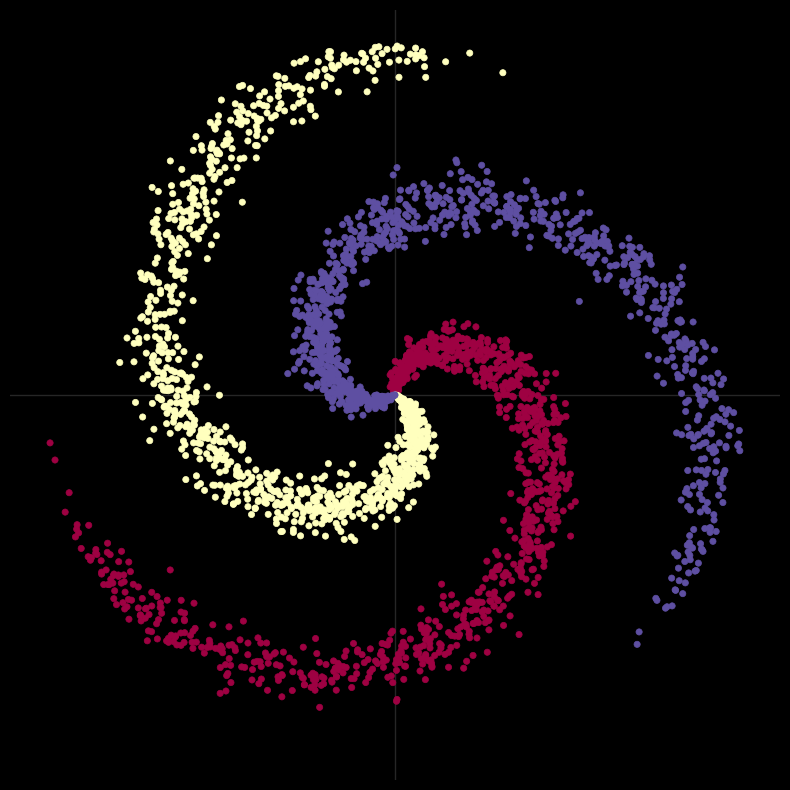

In [28]:
N = 1000  # num_samples_per_class
D = 2  # dimensions
C = 3  # num_classes
H = 100  # num_hidden_units
seed = 12345
key = jax.random.PRNGKey(seed)

# Creating synthetic data (spiral)
X = jnp.zeros((N * C, D))
y = jnp.zeros(N * C, dtype=jnp.int32)

X_list = []
y_list = []

key, subkey = jax.random.split(key)
for c in range(C):
    t = jnp.linspace(0, 1, N)
    inner_var = jnp.linspace(
        (2 * math.pi / C) * c,
        (2 * math.pi / C) * (2 + c),
        N
    ) + jax.random.normal(jax.random.fold_in(subkey, c), (N,)) * 0.2
    
    X_c = jnp.stack([t * jnp.sin(inner_var), t * jnp.cos(inner_var)], axis=1)
    y_c = jnp.full((N,), c, dtype=jnp.int32)
    
    X_list.append(X_c)
    y_list.append(y_c)

X = jnp.concatenate(X_list, axis=0)
y = jnp.concatenate(y_list, axis=0)

print("Shapes:")
print("X:", X.shape)
print("y:", y.shape)

pl.plot_data(X, y)

## 3. Definisi Model dengan Flax NNX

Berbeda dengan JAX murni yang mengelola parameter secara manual, Flax NNX menggunakan pendekatan berbasis kelas (`nnx.Module`). Pendekatan ini lebih intuitif bagi pengguna yang terbiasa dengan PyTorch atau Keras, namun tetap mempertahankan performa komputasi JAX.

Di sini kita mendefinisikan MLP dengan:
*   Dua lapisan tersembunyi (*hidden layers*) dengan 100 neuron.
*   Fungsi aktivasi ReLU.
*   Lapisan output dengan 3 neuron (sesuai jumlah kelas spiral).

In [29]:
class MLP(nnx.Module):
    def __init__(self, din, dhidden, dout, rngs: nnx.Rngs):
        self.l1 = nnx.Linear(din, dhidden, rngs=rngs)
        self.l2 = nnx.Linear(dhidden, dhidden, rngs=rngs)
        self.l3 = nnx.Linear(dhidden, dout, rngs=rngs)

    def __call__(self, x):
        x = nnx.relu(self.l1(x))
        x = nnx.relu(self.l2(x))
        return self.l3(x)

model = MLP(din=2, dhidden=100, dout=3, rngs=nnx.Rngs(0))
nnx.display(model)

## 4. Forward Pass & Preparasi Optimizer
Dengan NNX, kita juga menyiapkan optimizer yang terikat langsung dengan model. Kita menggunakan **Stochastic Gradient Descent (SGD)** dari Optax.

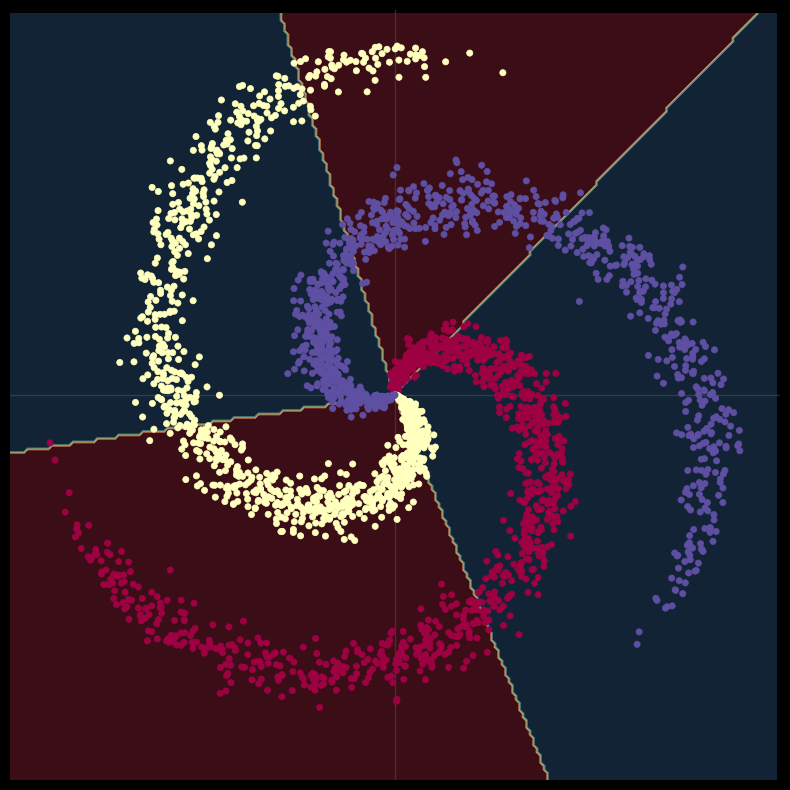

In [30]:
optimizer = nnx.Optimizer(model, optax.sgd(1e-2), wrt=nnx.Param)

# Plot model (before training)
pl.plot_model(X, y, model)

## 5. Fungsi Loss & Akurasi
Karena NNX berbasis stateful (objek model menyimpan variabel), kita menggunakan `nnx.value_and_grad` yang bekerja pada instance model.

In [31]:
def loss_fn(model, x, y):
    logits = model(x)
    return optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()

def accuracy_fn(model, x, y):
    logits = model(x)
    return jnp.mean(jnp.argmax(logits, axis=-1) == y)

In [32]:
# Test the loss function
loss = loss_fn(model, X, y)
print(f"Loss: {loss}") 

Loss: 1.1169347763061523


## 6. Pelatihan dengan nnx.Optimizer
Alur pelatihan di NNX sangat efisien. Kita membungkus proses update dalam `nnx.jit` untuk mendapatkan kecepatan eksekusi maksimal.

### Proses Pelatihan
Kita mencatat riwayat loss dan akurasi untuk divisualisasikan nanti.

Iteration    0, Loss: 1.1169, Accuracy: 0.3413
Iteration  100, Loss: 0.8974, Accuracy: 0.4943
Iteration  200, Loss: 0.8142, Accuracy: 0.5003
Iteration  300, Loss: 0.7711, Accuracy: 0.5087
Iteration  400, Loss: 0.7432, Accuracy: 0.5123
Iteration  500, Loss: 0.7210, Accuracy: 0.5203
Iteration  600, Loss: 0.7009, Accuracy: 0.5287
Iteration  700, Loss: 0.6813, Accuracy: 0.5393
Iteration  800, Loss: 0.6618, Accuracy: 0.5523
Iteration  900, Loss: 0.6420, Accuracy: 0.5787
Iteration 1000, Loss: 0.6214, Accuracy: 0.6047
Iteration 1100, Loss: 0.6000, Accuracy: 0.6510
Iteration 1200, Loss: 0.5782, Accuracy: 0.6933
Iteration 1300, Loss: 0.5559, Accuracy: 0.7440
Iteration 1400, Loss: 0.5330, Accuracy: 0.7960
Iteration 1500, Loss: 0.5095, Accuracy: 0.8370
Iteration 1600, Loss: 0.4859, Accuracy: 0.8677
Iteration 1700, Loss: 0.4621, Accuracy: 0.8873
Iteration 1800, Loss: 0.4384, Accuracy: 0.8990
Iteration 1900, Loss: 0.4151, Accuracy: 0.9107


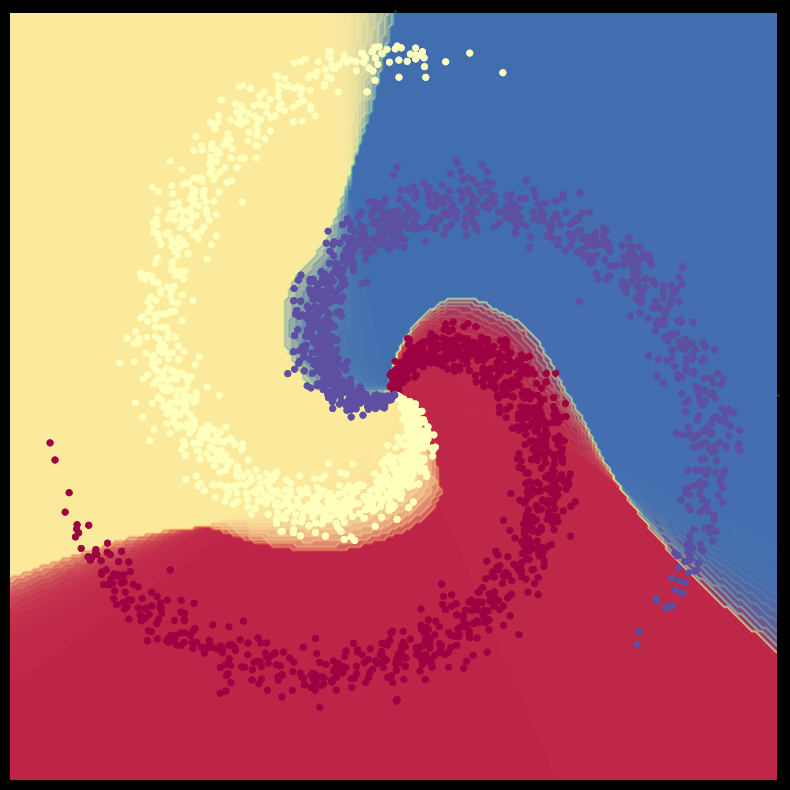

In [33]:
epochs = 2000
loss_history = []
acc_history = []
step_history = []

@nnx.jit
def train_step(model, optimizer, x, y):
    loss, grads = nnx.value_and_grad(loss_fn)(model, x, y)
    optimizer.update(model, grads)
    return loss

for i in range(epochs):
    loss = train_step(model, optimizer, X, y)
    loss_history.append(float(loss))
    
    if i % 100 == 0:
        acc = accuracy_fn(model, X, y)
        acc_history.append(float(acc))
        step_history.append(i)
        print(f'Iteration {i:4d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')
        
        pl.plot_model(X, y, model)

Final Accuracy: 0.9180


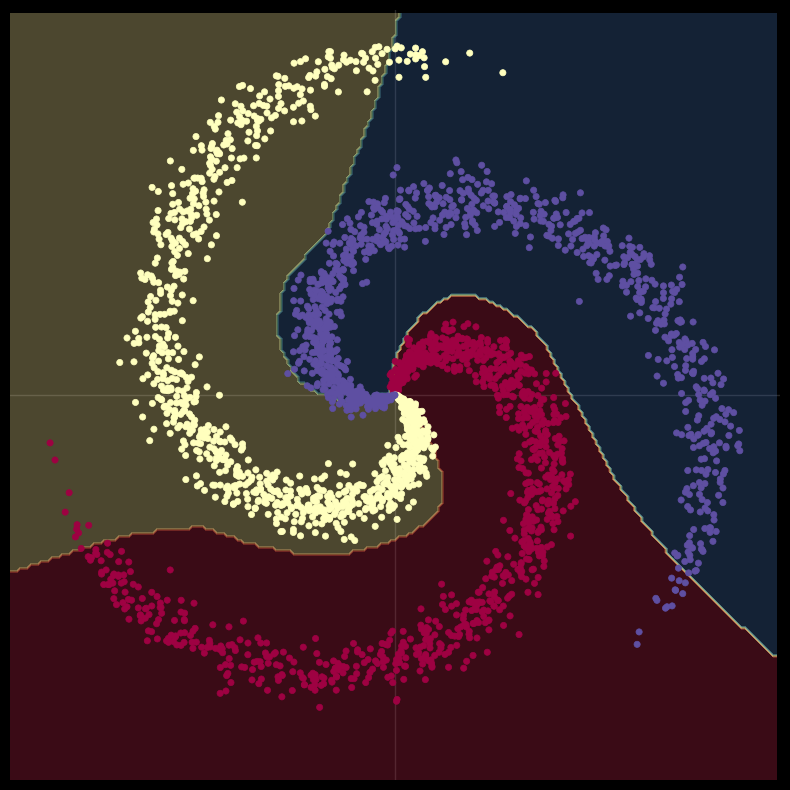

In [34]:
# Final model visualization
pl.plot_model(X, y, model)
print(f'Final Accuracy: {accuracy_fn(model, X, y):.4f}')

## 7. Visualisasi Metrik Pelatihan

Setelah proses pelatihan selesai, penting untuk melihat tren **loss** dan **akurasi**. Grafik ini membantu kita mendeteksi:
*   **Konvergensi**: Apakah loss terus turun dan stabil?
*   **Learning Rate**: Jika loss turun terlalu lambat atau berosilasi, kita mungkin perlu menyesuaikan *learning rate*.
*   **Overfitting**: Meskipun dalam dataset sederhana ini jarang terjadi, tren akurasi membantu memantau performa model.

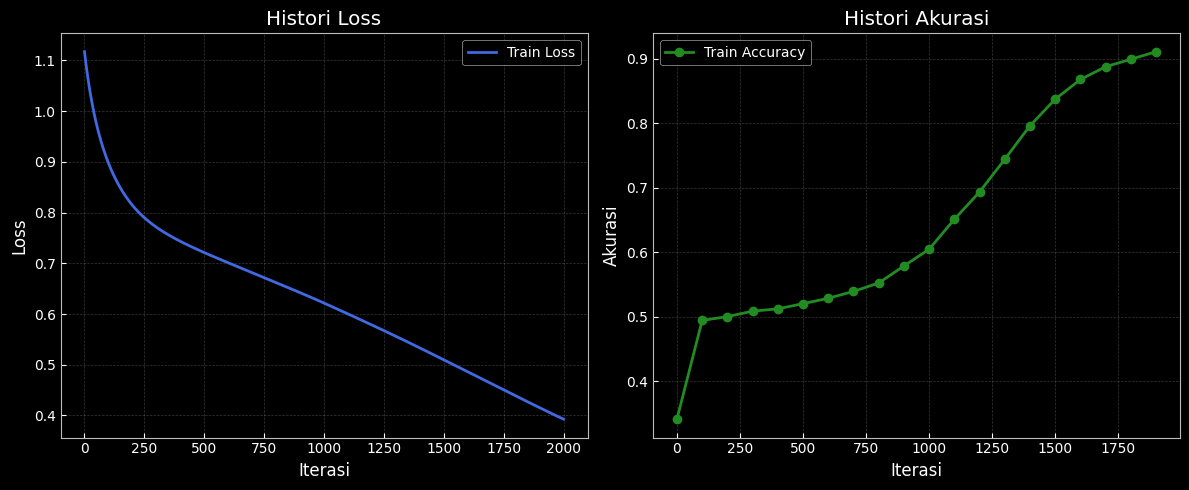

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Train Loss', color='royalblue')
plt.title('Histori Loss')
plt.xlabel('Iterasi')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot Akurasi
plt.subplot(1, 2, 2)
plt.plot(step_history, acc_history, label='Train Accuracy', color='forestgreen', marker='o')
plt.title('Histori Akurasi')
plt.xlabel('Iterasi')
plt.ylabel('Akurasi')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()